In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_30 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.mortality.final_model_loss_train_mortality import *
from model.final_model.mortality.final_model_mortality import PatientOutcomeModel
from model.retnet.autoencoder_v5_retnet import  TSAutoencoder
from model.final_model.mortality.plot import *


import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [2]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===

test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_test = MultiModalDataset(test_data_dir,global_node2idx)

test_loader = DataLoader(dataset_test,batch_size=8 ,collate_fn=collate_fn, shuffle=False)


Built 461 patient-tree graphs


In [3]:
flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30/stage3/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [4]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/mortality/resampled_30/best_joint.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

# Feature Importance Analysis

In [5]:
from captum.attr import IntegratedGradients

In [6]:
test_input = next(iter(test_loader))
_, flat_data, ts_data, graph_data, risk, ts_lengths, categories, mortality, _ = test_input

flat_data = flat_data.to(device)
flat_data.requires_grad = True
ts_data = ts_data.to(device)
ts_data.requires_grad = True
graph_data = graph_data.to(device)
graph_data.requires_grad = True

risk = risk.to(device)
ts_lengths = ts_lengths.to(device)
categories = categories.to(device)
mortality = mortality.to(device)

In [17]:
graph_data[0]

Data(x=[9, 62], edge_index=[2, 46], patient_id=[1], node_names=[9], mask=[9])

In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch_scatter import scatter_mean


def forward_for_contribution(flat_emb, graph_emb, ts_emb_seq, ts_lengths):
    # === Flat + Graph 融合 ===
    fused = model.fusion([flat_emb, graph_emb])  # [B, 32]

    # === LSTM on TS ===
    packed_output = pack_padded_sequence(ts_emb_seq, ts_lengths.cpu(), batch_first=True, enforce_sorted=False)
    packed_output, _ = model.mortality_predictor.lstm(packed_output)
    output, _ = pad_packed_sequence(packed_output, batch_first=True)  # [B, T, hidden_dim]
    # ==== Ts to fc ====
    ts_out = model.mortality_predictor.fc_ts(output)  # [B, T, 64]
    ts_out = model.mortality_predictor.drop(ts_out)
    # ==== Fused to fc ====
    fused_out = model.mortality_predictor.fc_fused(fused)  # [B, 64]
    fused_out = model.mortality_predictor.drop(fused_out)

    fused_out_exp = fused_out.unsqueeze(1).expand(-1, ts_out.size(1), -1)  # [B, T, 64]
    # === Combine Fused and TS  to predictor ===
    combine_exp = torch.cat([fused_out_exp, ts_out], dim=2)  # [B, T, 128]
    combine_out = model.mortality_predictor.fc_combine(combine_exp)  # [B, T, 1]

    output = torch.sigmoid(combine_out).squeeze(-1).mean(dim=1)  # [B]
    return output


def plot_module_contribution(contribution_dict):

    labels = list(contribution_dict.keys())
    values = list(contribution_dict.values())

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color=['mistyrose', 'moccasin', 'powderblue'])
    plt.ylabel('Attribution (L1 Sum)')
    plt.title('Embedding Module Contribution')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

In [8]:
from captum.attr import IntegratedGradients
model.eval()
flat_emb = model.flat_encoder(flat_data)  # [B, 32]

graph_x, edge_index, batch = graph_data.x, graph_data.edge_index, graph_data.batch
node_emb = model.graph_encoder(graph_x, edge_index)
mask = graph_data.mask.unsqueeze(-1)
graph_emb = scatter_mean(node_emb * mask, batch, dim=0)  # [B, 32]

ts_emb = model.ts_encoder(ts_data, ts_lengths)  # [B, T, 128]
ts_emb_pooled = ts_emb.mean(dim=1)  # (B, 128)

241 --- torch.Size([2, 106])
99 --- torch.Size([2, 106])
41 torch.Size([2, 106])
EDGE_INDEX: torch.Size([2, 106])		LOOP_INDEX: torch.Size([2, 41])
241 --- torch.Size([2, 106])
99 --- torch.Size([2, 106])
41 torch.Size([2, 106])
EDGE_INDEX: torch.Size([2, 106])		LOOP_INDEX: torch.Size([2, 41])


In [66]:
model.train()  # 避免 cuDNN RNN backward 报错

ig = IntegratedGradients(forward_for_contribution)

attributions = ig.attribute(
    inputs=(flat_emb, graph_emb, ts_emb),   #
    additional_forward_args=(ts_lengths,),  #
    n_steps=50
)

flat_attr, graph_attr, ts_attr = attributions

In [67]:
flat_contribution = flat_attr.abs().sum().item()
graph_contribution = graph_attr.abs().sum().item()
ts_contribution = ts_attr.abs().sum().item()

contribution = {
    'Flat': flat_contribution,
    'Graph': graph_contribution,
    'Time series': ts_contribution
}

print(contribution)

{'Flat': 0.23016453649061916, 'Graph': 0.7784396621378824, 'Time series': 4.230702827949905}


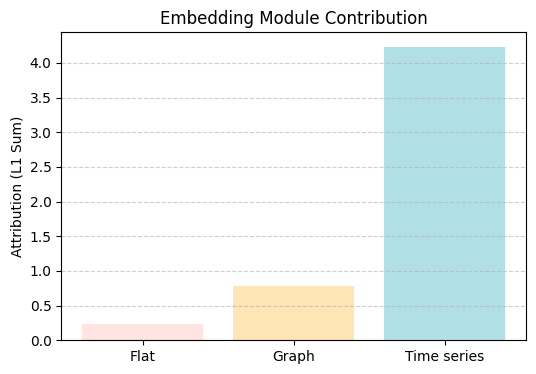

In [68]:
plot_module_contribution(contribution)

In [36]:
def plot_feature_attribution(
    attr_tensor, 
    feature_names, 
    sample_idx=None, 
    top_k=20,
    title=None
):

    if isinstance(attr_tensor, torch.Tensor):
        attr_tensor = attr_tensor.detach().cpu()


    if attr_tensor.dim() == 2:
        if sample_idx is not None:
            attr = attr_tensor[sample_idx].numpy()
            plot_title = f"Feature Attribution for Sample {sample_idx}"
        else:
            attr = attr_tensor.abs().mean(dim=0).numpy()
            plot_title = "Global Feature Attribution"
    elif attr_tensor.dim() == 1:
        attr = attr_tensor.numpy()
        plot_title = "Feature Attribution"
        
    elif  attr_tensor.dim() == 3:
        if sample_idx is not None:
            attr = attr_tensor[sample_idx].detach().abs().mean(dim=0).cpu().numpy()  # 平均时间
            plot_title = f"Feature Attribution for Sample {sample_idx} (Time Averaged)"
        else:
            attr = attr_tensor.abs().mean(dim=(0, 1)).detach().cpu().numpy()  # 平均 batch 和 时间
            plot_title = "Feature Attribution (Mean over Batch & Time)"

    if title is not None:
        plot_title = title


    # === 排序 ===
    sorted_idx = np.argsort(-np.abs(attr))
    if top_k is not None:
        sorted_idx = sorted_idx[:top_k]

    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_values = [attr[i] for i in sorted_idx]

    # === 绘图 ===
    plt.figure(figsize=(8, max(4, len(sorted_idx) * 0.4)))
    plt.barh(sorted_features, sorted_values, color='cornflowerblue')
    plt.xlabel('Attribution')
    plt.title(plot_title)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

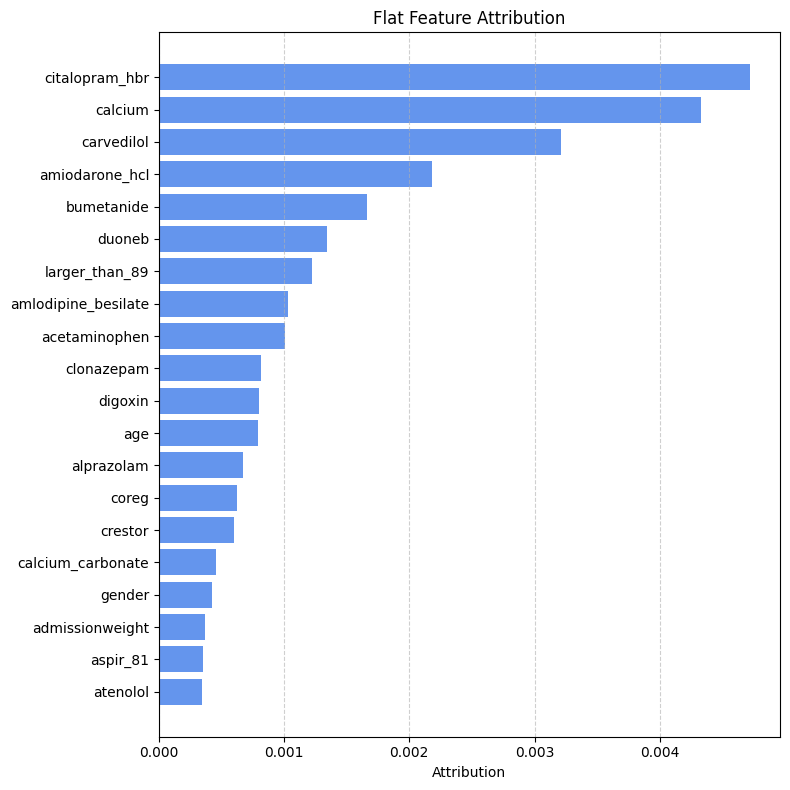

In [ ]:
with open('/home/mei/nas/docker/thesis/data/hdf/flat_features.txt', 'r') as f:
    flat_features = [line.strip() for line in f]

plot_feature_attribution(
    flat_attr,
    feature_names=flat_features,
    title="Flat Feature Importance"
)

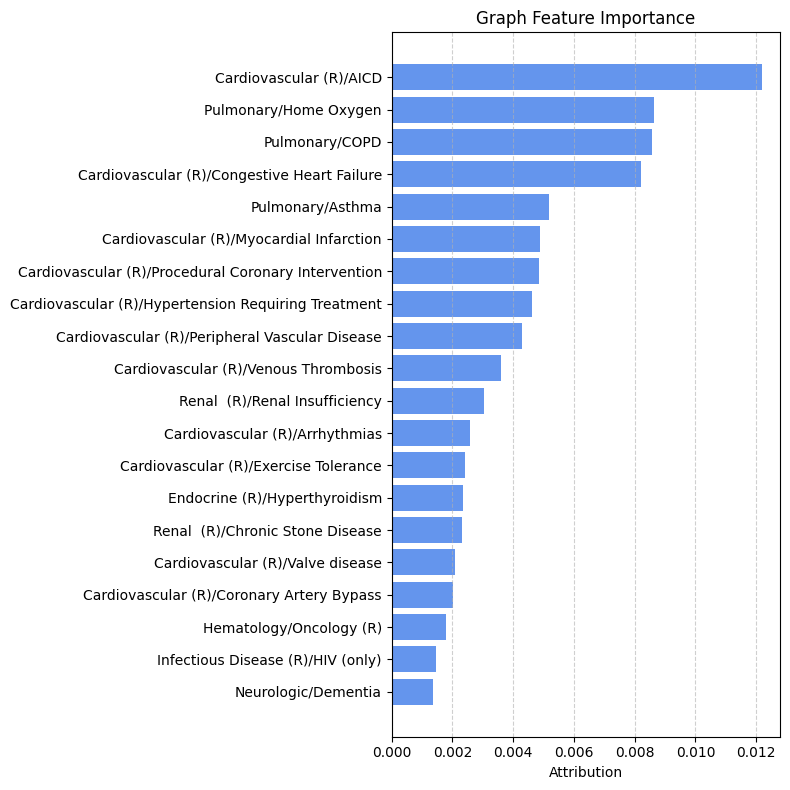

In [31]:
with open('/home/mei/nas/docker/thesis/data/hdf/diagnosis_features.txt', 'r') as f:
    diag_features = [line.strip() for line in f]

plot_feature_attribution(
    attr_tensor=graph_attr,
    feature_names=diag_features,
    title="Graph Feature Importance"
)

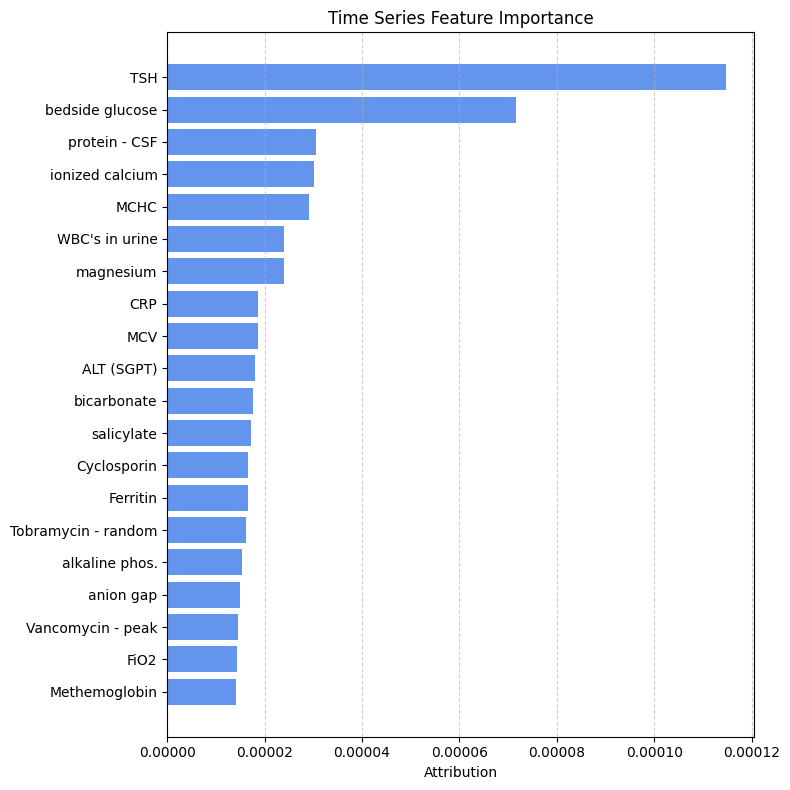

In [37]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    ts_features = [line.strip() for line in f]
    
plot_feature_attribution(
    attr_tensor=ts_attr,
    feature_names=ts_features,
    title="Time Series Feature Importance"
)

# 计算每个 embedding 单独的contribution

In [38]:
falt_attributions = ig.attribute(
    inputs=(flat_emb),   #
    additional_forward_args=( graph_emb, ts_emb,ts_lengths,),  #
    n_steps=50
)

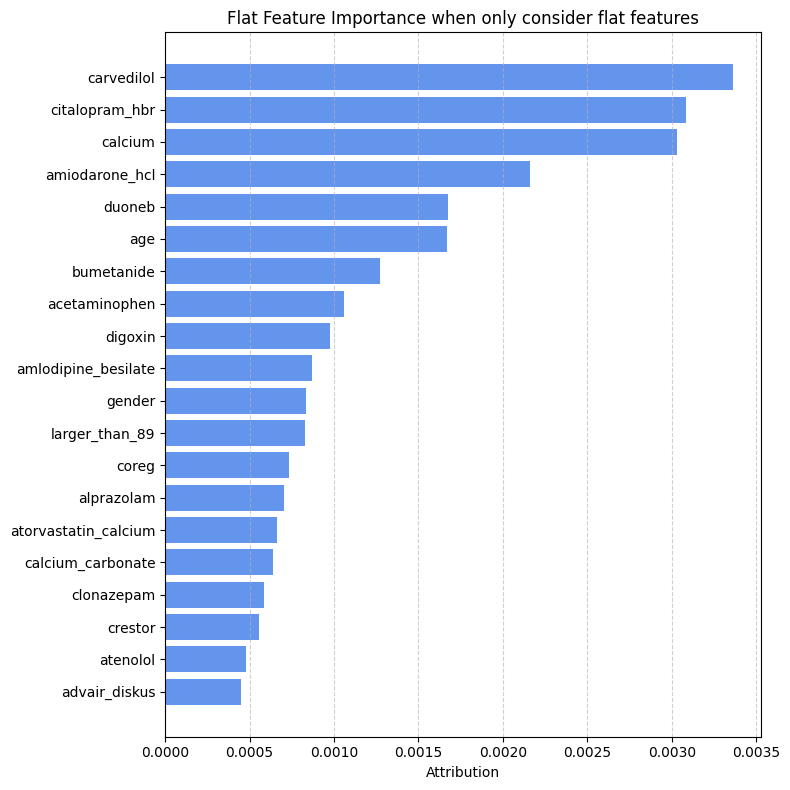

In [40]:
with open('/home/mei/nas/docker/thesis/data/hdf/flat_features.txt', 'r') as f:
    flat_features = [line.strip() for line in f]

plot_feature_attribution(
    falt_attributions,
    feature_names=flat_features,
    title="Flat Feature Importance when only consider flat features"
)

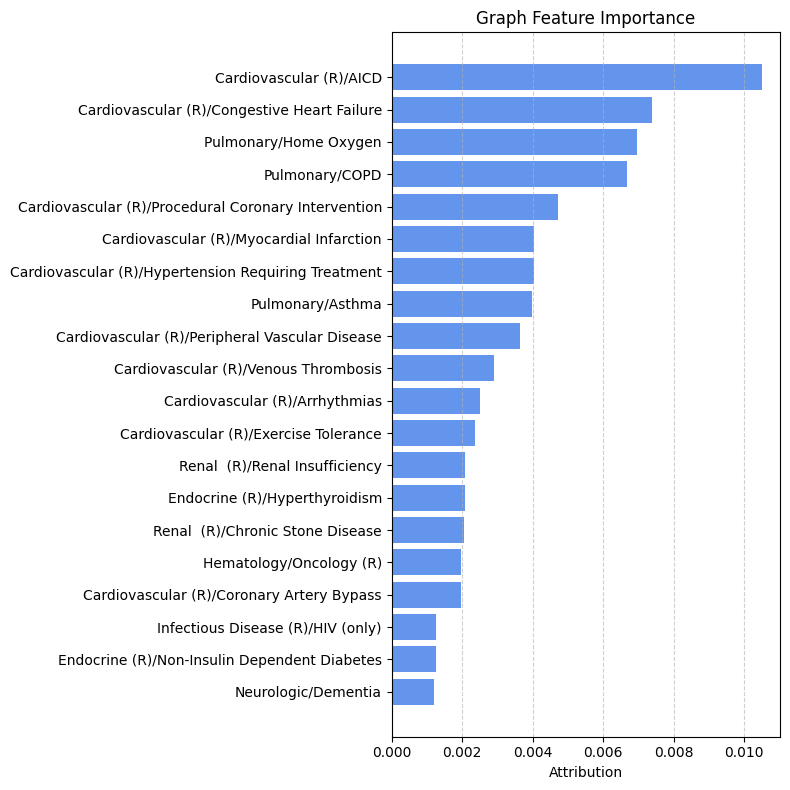

In [56]:
graph_attributions = ig.attribute(
    inputs=(graph_emb),   #
    additional_forward_args=( flat_emb, ts_emb,ts_lengths),  #
    n_steps=50
)
with open('/home/mei/nas/docker/thesis/data/hdf/diagnosis_features.txt', 'r') as f:
    diag_features = [line.strip() for line in f]

plot_feature_attribution(
    attr_tensor=graph_attributions,
    feature_names=diag_features,
    title="Graph Feature Importance"
)

In [ ]:
def main_forward(fused, ts_emb, ts_lengths):
    packed_output = pack_padded_sequence(ts_emb, ts_lengths.cpu(), batch_first=True, enforce_sorted=False)
    packed_output, _ = model.mortality_predictor.lstm(packed_output)
    output, _ = pad_packed_sequence(packed_output, batch_first=True)

    ts_out = model.mortality_predictor.fc_ts(output)
    ts_out = model.mortality_predictor.drop(ts_out)

    fused_out = model.mortality_predictor.fc_fused(fused)
    fused_out = model.mortality_predictor.drop(fused_out)

    fused_out_exp = fused_out.unsqueeze(1).expand(-1, ts_out.size(1), -1)
    combine_exp = torch.cat([fused_out_exp, ts_out], dim=2)
    combine_out = model.mortality_predictor.fc_combine(combine_exp)

    output = torch.sigmoid(combine_out).squeeze(-1).mean(dim=1)  # [B]
    return output
def forward_ts(ts_emb):
    fused = model.fusion([flat_emb, graph_emb])  
    return main_forward(fused, ts_emb, ts_lengths)


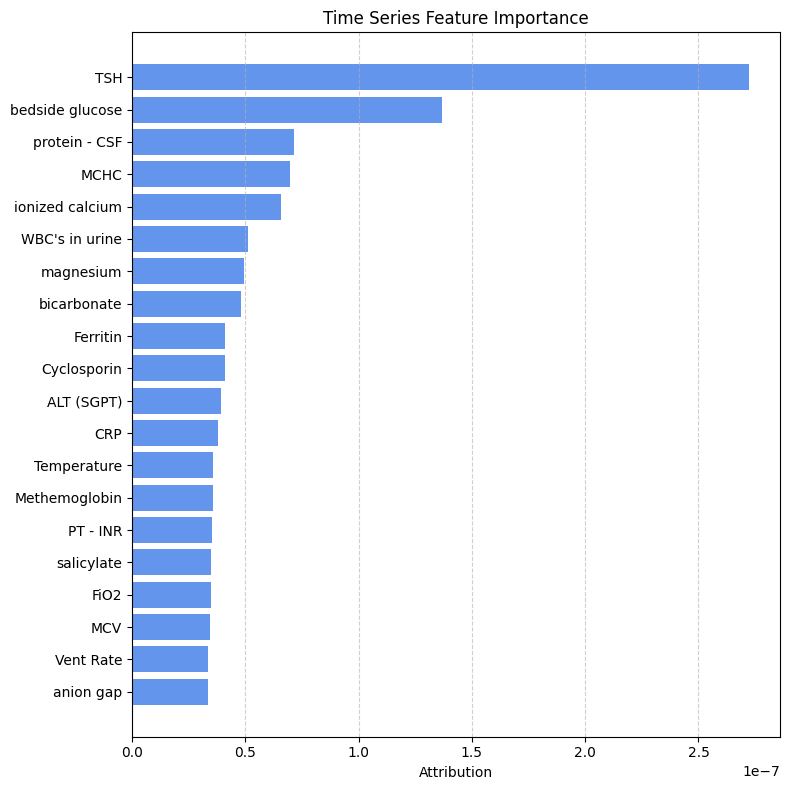

In [63]:
model.train()  # 避免 cuDNN RNN backward 报错

ig = IntegratedGradients(forward_ts)

ig_ts = IntegratedGradients(forward_ts)
ts_attributions  = ig_ts.attribute(
    inputs=ts_emb,
    n_steps=50
)
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    ts_features = [line.strip() for line in f]
    
plot_feature_attribution(
    attr_tensor=ts_attributions,
    feature_names=ts_features,
    title="Time Series Feature Importance"
)